<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>

In [1]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h1> 1. Data Specification </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [2]:
#setting seed
set.seed(9876)

## 2023 CoV Property Tax Report Dataset
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",")

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
#filter for housing properties
#also tidy up data, make lat and long dbl instead of chr, remove NA's
property_housing_only <- ptax_parcel_merged |>
    drop_na() |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      "Single Detached House",
                                      "Multiple Dwelling")) |>
    mutate(lat = as.double(lat)) |>
    mutate(long =  as.double(long))
head(property_housing_only)

#summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


LEGAL_TYPE,LAND_COORDINATE,ZONING_CLASSIFICATION,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,NEIGHBOURHOOD_CODE,TAX_LEVY,lat,long
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
STRATA,32071895,Comprehensive Development,597000,350000,2016,2016,023,2633.33,49.23355,-123.0242
LAND,79015654,Multiple Dwelling,2733000,422000,1988,1988,011,11066.10,49.22606,-123.1223
STRATA,81315093,Comprehensive Development,1530000,343000,2004,2004,011,5208.25,49.21761,-123.1276
LAND,74119765,Single Detached House,1928000,100000,1973,1975,016,8177.27,49.23645,-123.0945
LAND,75718836,Single Detached House,1851000,1125000,2020,2020,016,8717.36,49.23005,-123.1029
LAND,75719563,Single Detached House,1695000,294000,1921,2005,016,8517.75,49.23047,-123.0983


ZONING_CLASSIFICATION,COUNT
<chr>,<int>
Comprehensive Development,26394
Multiple Dwelling,10445
Single Detached House,21907


<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation. The first set of centroids consist of those that take into consideration all types of properties within a neighbourhood, and the second set of centroids consist of those that only take the locations of strata housing into consideration.  

<h2> Neighbourhood Centroids using All Properties </h2>

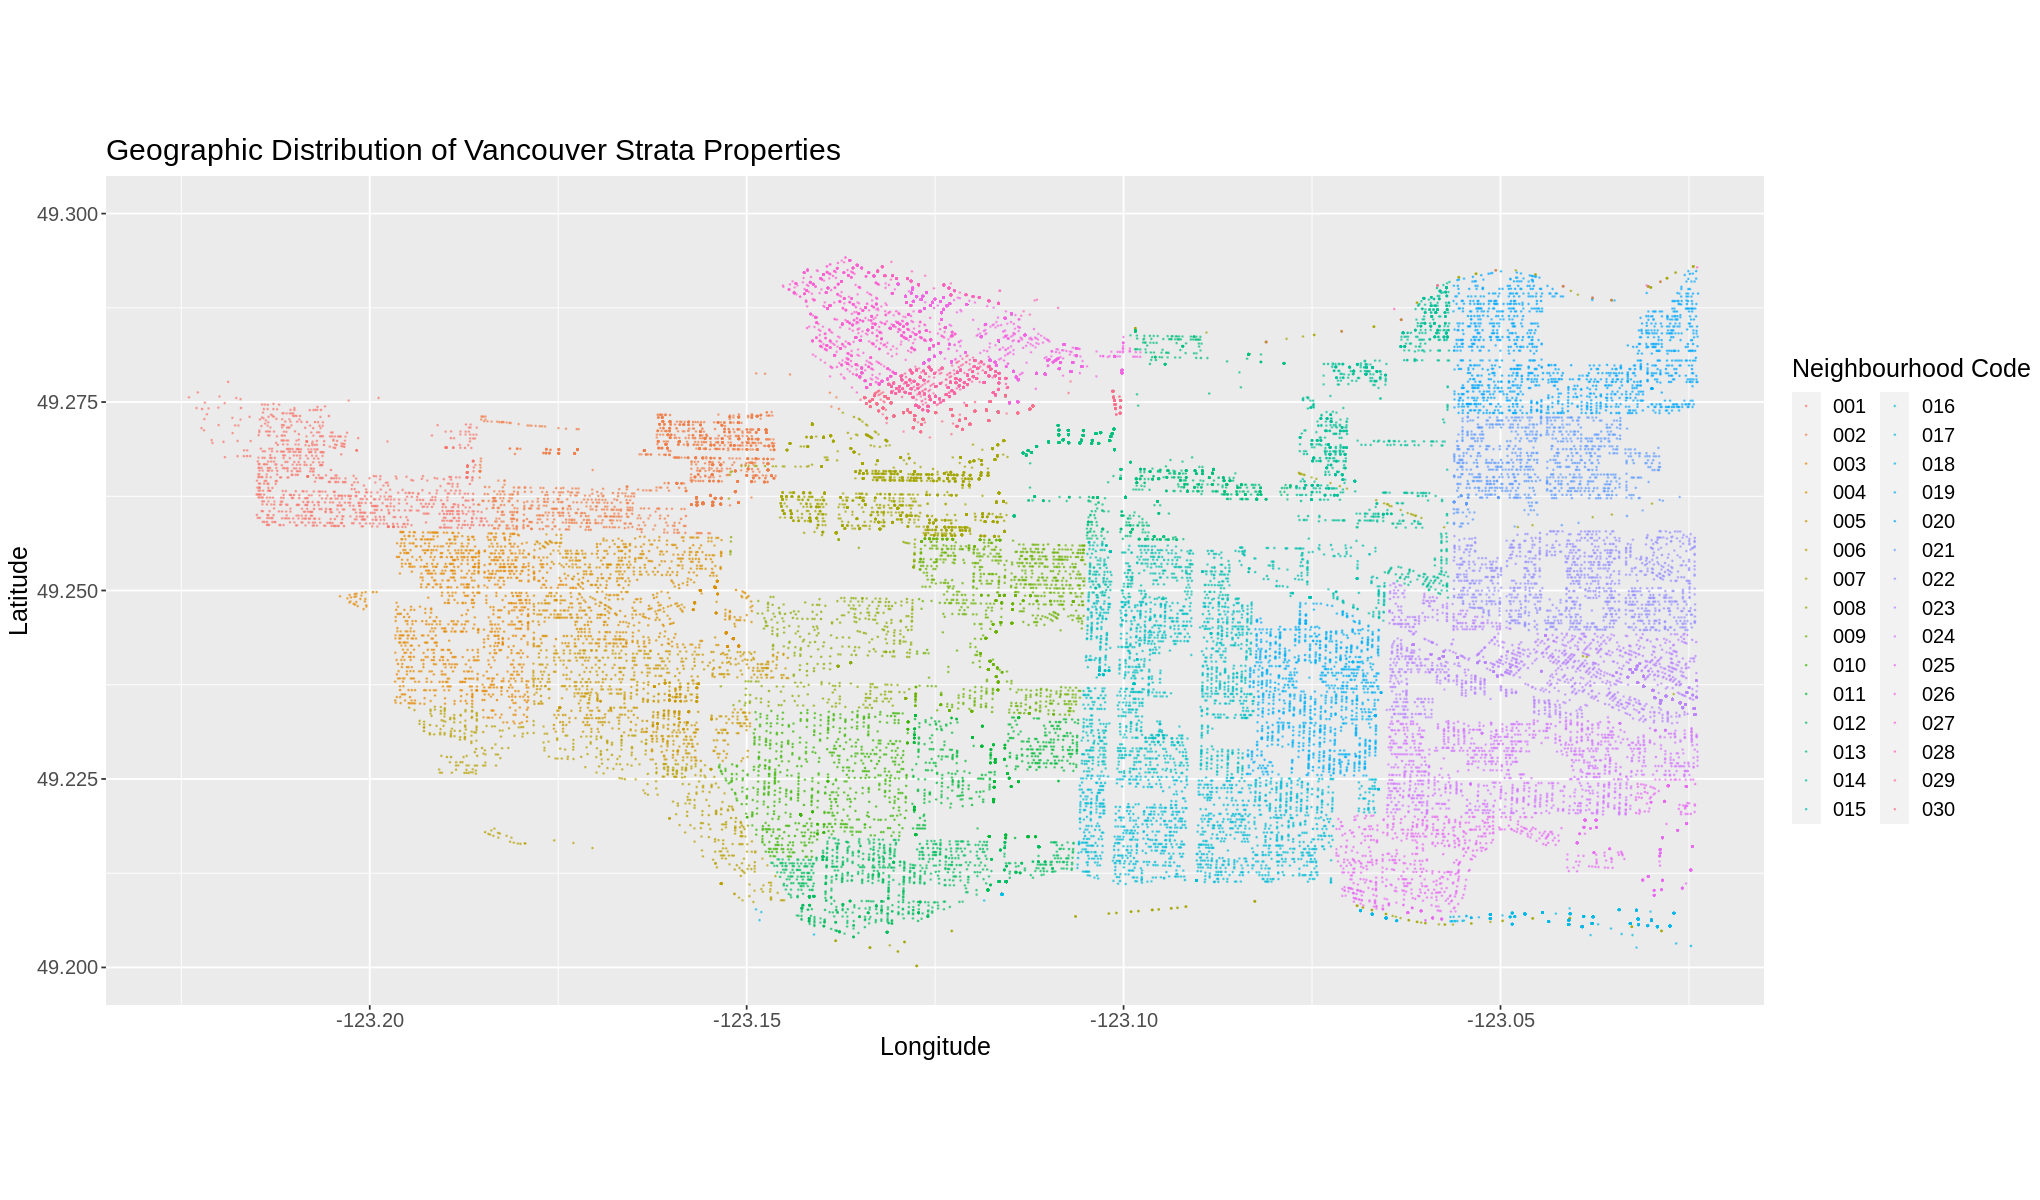

In [13]:
# This plot shows the spatial distribution of all properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
property_plot <- property_train |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
property_plot

<h2> Neighbourhood Centroids using Strata Properties Only </h2>

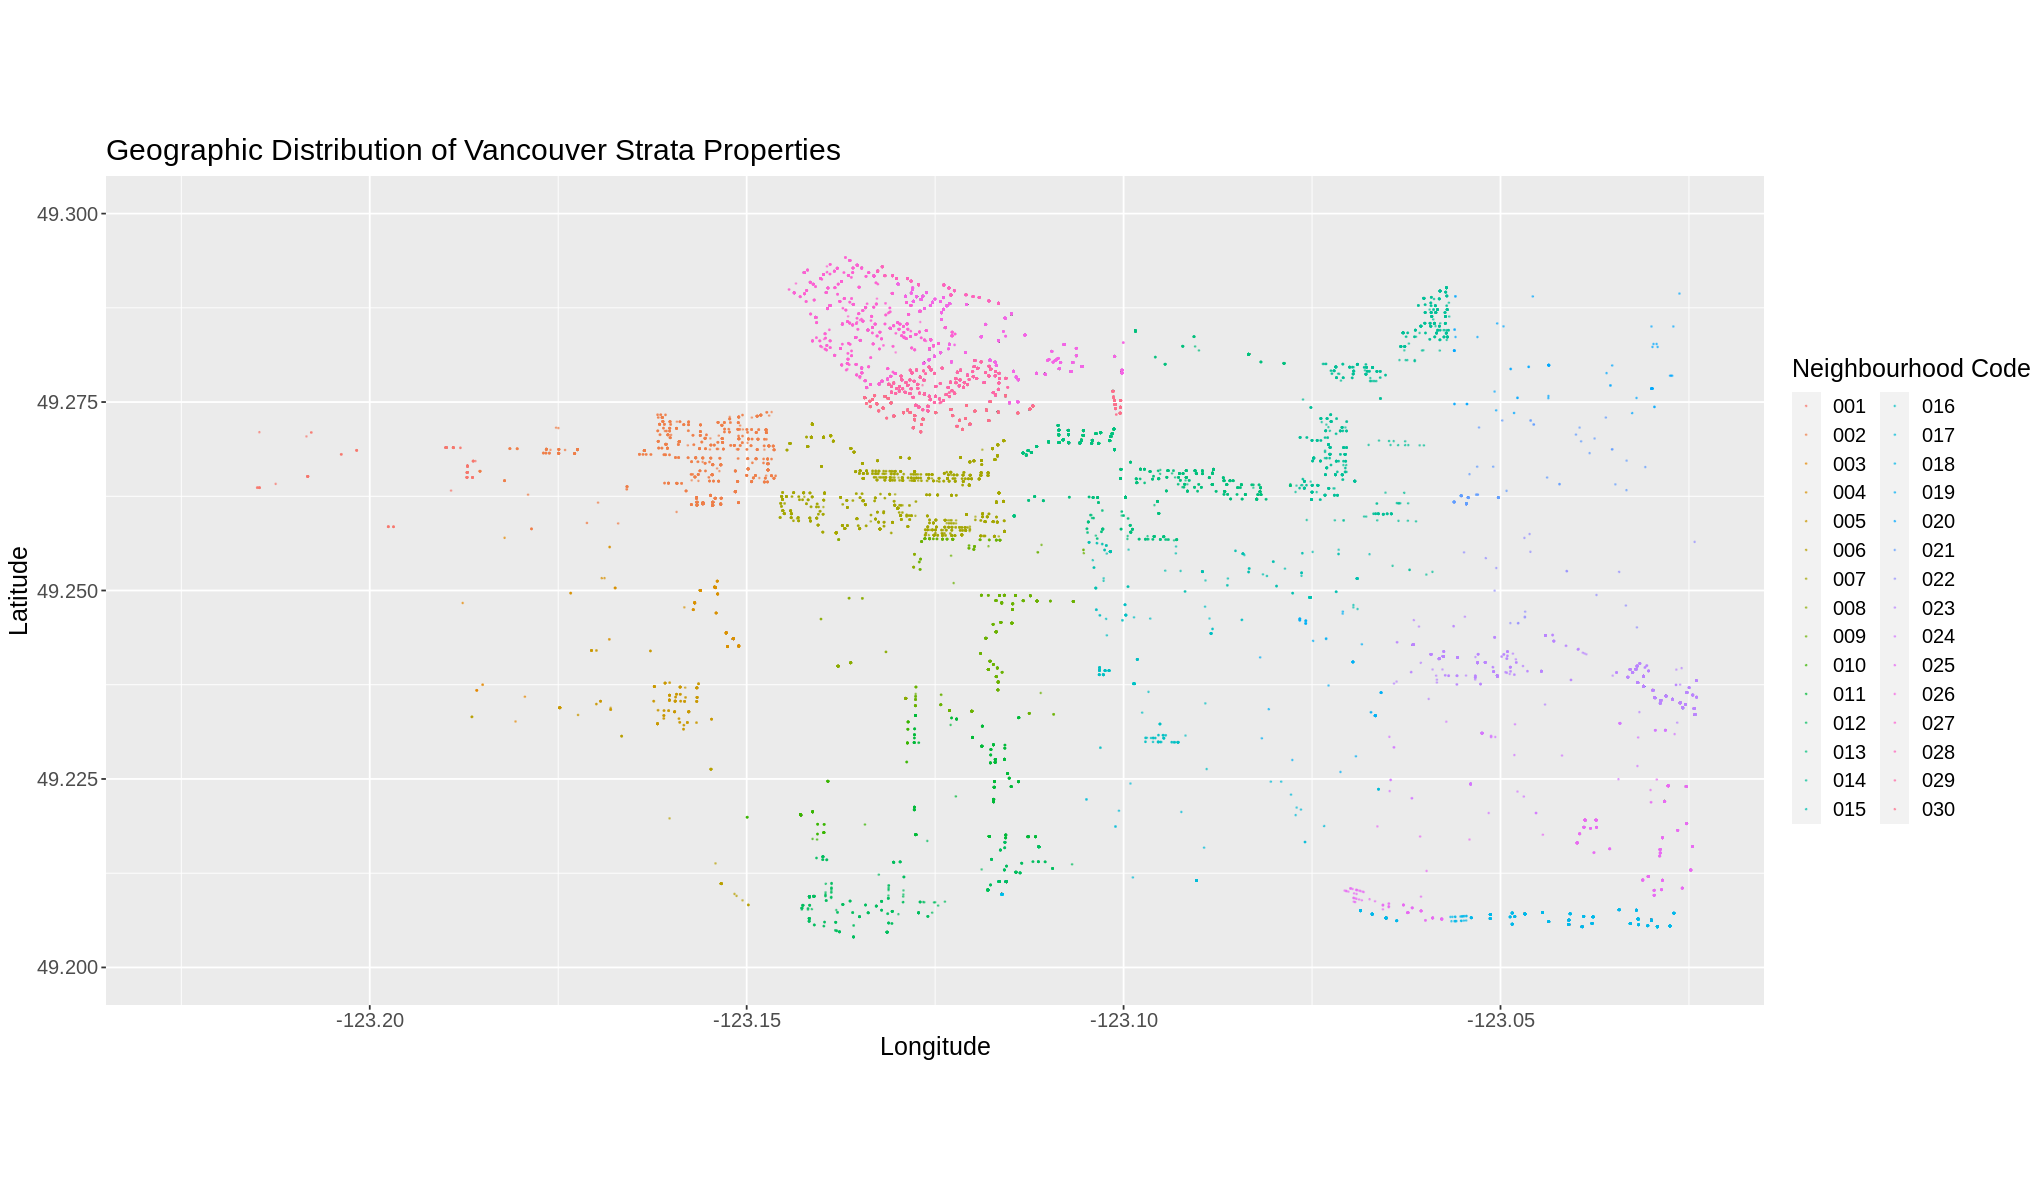

In [8]:
# This plot shows the spatial distribution of strata properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
strata_only_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_plot

In [11]:
# Strata Housing Centroids
# Group by, summarize, and plot




<h1> 3. Model Parameter Tuning </h1> 
The model will be tuned a priori using the elbow plot method, and will qualitively compare the results using the calculated spatial centroids from Section 3 above.

In [7]:
head(property_housing_only)



# scaled_reviews <- property_housing_only |>
#     mutate(across(everything(), scale))

# elbow_stats <- tibble(k = 1:10) |>
#     rowwise() |>
#     mutate(reviews_cluster = list(kmeans(scaled_reviews, nstart = 100, k))) |>
#     mutate(glanced = list(glance(reviews_cluster))) |>
#     select(-reviews_cluster) |>
#     unnest(glanced)

# tourism_elbow_plot <- elbow_stats |>
#     ggplot(aes(x = k, y = tot.withinss)) +
#     geom_point() +
#     geom_line() +
#     labs(x = "K", y = "WSSD", title = "Tourism Elbow Plot")
# tourism_elbow_plot

LEGAL_TYPE,LAND_COORDINATE,ZONING_CLASSIFICATION,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,NEIGHBOURHOOD_CODE,TAX_LEVY,lat,long
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
STRATA,32071895,Comprehensive Development,597000,350000,2016,2016,023,2633.33,49.23355024526444,-123.02419303447766
LAND,79015654,Multiple Dwelling,2733000,422000,1988,1988,011,11066.10,49.22605818650596,-123.1223039772827
STRATA,81315093,Comprehensive Development,1530000,343000,2004,2004,011,5208.25,49.21760827538108,-123.12755788861944
LAND,74119765,Single Detached House,1928000,100000,1973,1975,016,8177.27,49.23645452679151,-123.09452545114266
LAND,75718836,Single Detached House,1851000,1125000,2020,2020,016,8717.36,49.23004757185115,-123.10294984727336
LAND,75719563,Single Detached House,1695000,294000,1921,2005,016,8517.75,49.2304708918118,-123.0982793251052


<h2> </h2>

<h1> 4. Clustering Model </h1>

In [ ]:
# DON'T CHANGE THE SEED VALUE!
set.seed(9876)

<h1> 5. Results Discussion </h1>

<h1> 6. Conclusion </h1>

<h1> 7. References and Resources </h1>